In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3582646291


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 500,
    "to_freeze_count": 155
}

optuna_result_attachement = {
    'lr': 0.001,
    'lr_end': 0.00016,
    'power': 0.72,
    'scheduler': 'polynomial_decay_schedule_with_warmup',
    'warmup_factor': 0
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 0,
 'scheduler': 'polynomial_decay_schedule_with_warmup',
 'lr_end': 0.00016,
 'power': 0.72,
 'freeze_from_steps': -1,
 'seed': 3582646291,
 'num_epoch': 500,
 'to_freeze_count': 155}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
***** Running training *****
  Num examples = 1222
  Num Epochs = 500
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 19500


[0] set freeze_part_layers: True (freezing 155 out of 160 layers.)


Step,Training Loss
39,2.537500
78,2.114300
117,2.021000
156,1.942400
195,1.940100
234,1.872700
273,1.867900
312,1.858300
351,1.779500
390,1.776500


Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [/opt/awsw/models/awsw_main/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-2000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint

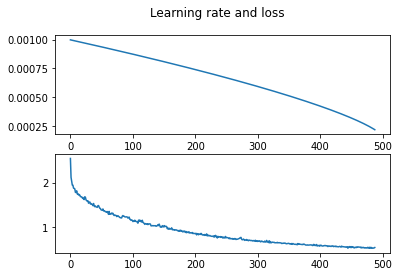

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "Very nice."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "You too!" Ry "I hope you are ready to see your beautiful newirene." DragonReply m "I hope you are ready to see your beautiful newirene." DragonReply Ry "You too!"<|endoftext|>


Prompt: What do you think of Lorem?
Reply: Ad "I think they're both pretty big, but even I couldn't pinpoint the reason why they're not as large as Lorem. I couldn't pinpoint the reason why I think they're not as small as Lorem."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: Ry "This is something I had to do. I couldn't wait for this."<|endoftext|>


Prompt: What will we do here?
Reply: An "We sat down in Anna's lab, right in the middle of one of her office buildings. Anna was the one who had us there, right in the middle of one of the offices of Anna's roommanaise."<|endoftext|>




# Sampling test

Which combination is the best?

In [9]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 92, top_p: 0.68] -> Prompt: How are you?
Reply: Ry "Iizarre, I'll life for a few minutes."<|endoftext|>

[Test 1 top_k: 92, top_p: 0.68] -> Prompt: What do you think of Lorem?
Reply: Ad "I think they're both pretty big, but I like them very much. I'd like to see someAPE."<|endoftext|>

[Test 1 top_k: 92, top_p: 0.68] -> Prompt: Oh my god, Adine. What is this?
Reply: Ry "This is what?"<|endoftext|>

[Test 1 top_k: 92, top_p: 0.68] -> Prompt: What will we do here?
Reply: An "We sat down in Anna's lab, right in the middle of one of her office applications."<|endoftext|>

-------------
[Test 2 top_k: 53, top_p: 0.56] -> Prompt: How are you?
Reply: Ry "Iizarre, I'll life for a few minutes."<|endoftext|>

[Test 2 top_k: 53, top_p: 0.56] -> Prompt: What do you think of Lorem?
Reply: Ad "I think they're both pretty big, but even I couldn't pinpoint the reason why they're not exactly the same thing."<|endoftext|>

[Test 2 top_k: 53, top_p: 0.56] -> Prompt: Oh my god, Adine. What 

In [10]:
model_manager = ModelManager(checkpoint_dirs[-1])
print("What to say?")
print(generate_dragon_reply("", input()))

NameError: name 'checkpoint_dirs' is not defined